In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

In [2]:
project_root = '/user_data/mmhender/featsynth/'

In [3]:
expt_name = 'pilot1'

data_folder = os.path.join(project_root, 'online_data', expt_name)
expt_design_folder = os.path.join(project_root, 'expt_design', expt_name)

In [4]:
folders = os.listdir(data_folder)
folders = [f for f in folders if os.path.isdir(os.path.join(data_folder,f))]
folders = [f for f in folders if 'data' in f]
# folders = [folders[1]]
folders

['data_exp_104845-v9', 'data_exp_104845-v11']

In [5]:
raw_data = []

for ff in range(len(folders)):
        
    subfolder = os.path.join(data_folder, folders[ff])
    files = os.listdir(subfolder)
    files = [f for f in files if 'task' in f and '.csv' in f]
    task_filename = os.path.join(subfolder,files[0])
    print(task_filename)

    r = pd.read_csv(task_filename)
    
    raw_data += [r]
    
raw_data = pd.concat(raw_data, axis=0)

/user_data/mmhender/featsynth/online_data/pilot1/data_exp_104845-v9/data_exp_104845-v9_task-sq8b.csv
/user_data/mmhender/featsynth/online_data/pilot1/data_exp_104845-v11/data_exp_104845-v11_task-sq8b.csv


In [6]:
task_version = raw_data['Task Version']
experiment_version = raw_data['Experiment Version']
np.unique(np.array(experiment_version)), np.unique(np.array(task_version))

(array([ 9., 11., nan]), array([14., nan]))

In [7]:
private_ids = np.array(raw_data['Participant Private ID'])
public_ids = np.array(raw_data['Participant Public ID'])
my_ids = np.array(raw_data['subject_id_rnd'])
public_ids = [p if isinstance(p,str) else '' for p in public_ids]

print(np.unique(private_ids), np.unique(public_ids), np.unique(my_ids))

subject_ids = np.unique(private_ids)
subject_ids = subject_ids[~np.isnan(subject_ids)]
n_subjects = len(subject_ids)

[7494803. 7519817. 7519877. 7519886. 7519925. 7520275. 7594572. 7594906.
 7594960. 7595246.      nan] ['' '0yt4ywmv' '2yrs98lj' '4cntwgpn' '4qlnnzsd' '5ploo1az' '76bhcm4d'
 '7povpisi' 'bw0mm82w' 'jkjn531f' 'msadf654'] [ 2004.  7999. 20482. 23174. 46863. 52631. 58937. 87104. 91697. 99091.
    nan]


In [8]:
n_subjects

10

In [9]:
super_names_eachset = []
basic_names_eachset = []

for which_cb in [1,2]:
    info_filename = os.path.join(expt_design_folder, 'trial_info_counterbal%d.csv'%which_cb)
    info = pd.read_csv(info_filename)
    
    super_names = np.unique(info['super_name'])
    basic_names = []
    for sup in super_names:
        basic = np.unique(np.array(info['basic_name'][info['super_name']==sup]))
        basic_names += [basic]
        
    super_names_eachset += [super_names]    
    basic_names_eachset += [basic_names]
    
n_supcat = len(super_names_eachset[0])
n_bascat = len(basic_names_eachset[0][0])
n_supcat, n_bascat

(6, 6)

In [14]:
intact_cond = ['orig' in name for name in list(info['image_name'])]

In [10]:
def preproc_data(data):
    
    start_run_inds = np.where(~np.isnan(data['subject_id_rnd']))[0][0::2]
    stop_run_inds = np.where(~np.isnan(data['subject_id_rnd']))[0][1::2]
    finish_inds = stop_run_inds+1

    # print(data.shape)
    # print(finish_inds)
    run_acc = np.array(data['total_acc'])[finish_inds]
    run_avg_rts = np.array(data['average_rt'])[finish_inds]
    print('run accuracies, avg RTs:')
    print(run_acc, run_avg_rts)

    which_cb = int(np.array(data['which_counterbal'])[start_run_inds[0]])
    # which_cb = 1
    print(which_cb)
    
    info_filename = os.path.join(expt_design_folder, 'trial_info_counterbal%d.csv'%which_cb)
    info = pd.read_csv(info_filename)

    n_trials = np.sum(data['is_stim'])
    assert(info.shape[0]==n_trials)

    trial_data = pd.DataFrame()
    rts = np.array(data['Reaction Time'])
    stim_rts = rts[data['is_stim']==True]
    iti_rts = rts[data['is_iti']==True]

    stimulus_dur_ms = 500

    rts = stim_rts
    rts[np.isnan(stim_rts)] = iti_rts[np.isnan(stim_rts)] + stimulus_dur_ms

    trial_data['rt'] = rts

    resp = np.array(proc_resp_strs(data['Response']))

    stim_resp = resp[data['is_stim']==True]
    iti_resp = resp[data['is_iti']==True]
    resp = stim_resp
    resp[np.isnan(stim_resp)] = iti_resp[np.isnan(stim_resp)]

    trial_data['resp'] = resp.astype(int)

    correct_resp = np.array(data['correct_response'])
    correct_resp = correct_resp[data['is_stim']==True].astype(int)

    # double check that trial sequence is correct between data and trial info csv
    correct_resp_check = 2-info['target_present'].astype(int)
    # print(correct_resp_check, correct_resp)
    # print(correct_resp_check==correct_resp)
    # print(np.where(~(correct_resp_check==correct_resp)))
    assert(np.all(correct_resp_check==correct_resp))

    trial_data['correct_resp'] = correct_resp

    trial_data['correct'] = trial_data['correct_resp']==trial_data['resp']
    
    return trial_data, info

def proc_resp_strs(resp, poss_resp = ['1','2']):

    resp = [r if isinstance(r, str) else str(r) for r in resp]
    proc_resp = np.array([int(r) if r in poss_resp else np.nan for r in resp])

    return proc_resp

In [78]:
288/72

4.0

In [11]:
subject_data = []
subject_info = []
subject_cb = np.zeros((n_subjects,))

# for si in [6]:
    # ss = subject_ids[si]
for si, ss in enumerate(subject_ids):
    
   
    d = raw_data.iloc[private_ids==ss]
    
    # sort by time. sometimes they are out of order, sometimes not...
    t = d['Local Timestamp']
    
    d = d.iloc[np.argsort(t)]
    
    which_cb = np.array(d['which_counterbal'])
    which_cb = int(which_cb[~np.isnan(which_cb)][0])
#     
    # which_cb = 1
    
    subject_cb[si] = which_cb
    
    pub_id = np.array(d['Participant Public ID'])[0]
    print('\nsubject %d, id: %s'%(si, pub_id))
    print('counterbalance cond: %d'%which_cb)
    # print(d.shape)
#     
    trial_data, info = preproc_data(d)
    
    subject_data += [trial_data]
    subject_info += [info]
   


subject 0, id: 0yt4ywmv
counterbalance cond: 1
run accuracies, avg RTs:
[78. 86. 78. 86. 83. 90. 92. 79. 89. 89.] [722. 713. 681. 740. 743. 700. 796. 696. 670. 717.]
1

subject 1, id: jkjn531f
counterbalance cond: 1
run accuracies, avg RTs:
[78. 83. 72. 79. 85. 81. 86. 83. 81. 82.] [765. 677. 621. 576. 636. 687. 646. 638. 623. 599.]
1

subject 2, id: msadf654
counterbalance cond: 2
run accuracies, avg RTs:
[83. 83. 89. 92. 89. 88. 92. 90. 88. 92.] [632. 542. 534. 535. 555. 535. 557. 486. 557. 527.]
2

subject 3, id: 76bhcm4d
counterbalance cond: 2
run accuracies, avg RTs:
[63. 79. 76. 79. 76. 78. 81. 76. 74. 81.] [665. 681. 614. 630. 595. 633. 590. 592. 644. 610.]
2

subject 4, id: 4qlnnzsd
counterbalance cond: 1
run accuracies, avg RTs:
[35. 51. 36. 50. 40. 28. 35. 49. 46. 36.] [399. 284. 156. 240. 228. 342. 122. 248. 307. 372.]
1

subject 5, id: 2yrs98lj
counterbalance cond: 1
run accuracies, avg RTs:
[11. 15. 19. 31. 22. 26. 25. 15. 31. 33.] [ 574.  757.  814.  866.  770.  825.  90

In [12]:
info = subject_info[0]

cue_level_vals = np.unique(info['cue_level'])
n_cue_levels = len(cue_level_vals)

image_type_vals = np.unique(info['image_type_num'])
n_image_types = len(image_type_vals)

acc_by_condition = np.zeros((n_subjects, n_cue_levels, n_image_types))
propyes_by_condition = np.zeros((n_subjects, n_cue_levels, n_image_types))
overall_acc = np.zeros((n_subjects,))

acc_by_supcat = [np.zeros((np.sum(subject_cb==cb), n_cue_levels, n_image_types, n_supcat)) \
                 for cb in [1,2]]
cb_sub_count = [0,0]

for si in range(n_subjects):
    
    info = subject_info[si]
    trial_data = subject_data[si]
    
    overall_acc[si] = np.mean(trial_data['correct'])

    if subject_cb[si]==1:
        cbi=0;
    else:
        cbi=1;

    supnames = super_names_eachset[cbi]
      
    for cc, cue in enumerate(cue_level_vals):

        for ii, imtype in enumerate(image_type_vals):

            inds = (info['cue_level']==cue) & (info['image_type_num']==imtype)

            acc_by_condition[si, cc,ii] = np.mean(trial_data['correct'][inds])

            propyes_by_condition[si, cc,ii] = np.mean(trial_data['resp'][inds]==1)
            
            for sc, supcat in enumerate(supnames):
                
                inds = (info['cue_level']==cue) & \
                        (info['image_type_num']==imtype) & \
                        (info['super_name']==supcat)
                
                acc_by_supcat[cbi][cb_sub_count[cbi],cc,ii,sc] = np.mean(trial_data['correct'][inds])

    cb_sub_count[cbi]+=1
     

In [14]:
# as quality control, check accuracy on the intact condition. subjects
# should all be above 0.50 on this since it's easy.
intact_acc = np.mean(acc_by_condition[:,:,0], axis=1)
subjects_use = intact_acc>0.50
subjects_use

array([ True,  True,  True,  True, False, False, False,  True, False,
       False])

In [16]:
image_type_names = np.array(['intact', 'match pool1', 'match pool2', 'match pool3', 'match pool4'])
cue_level_names = ['cue basic', 'cue superordinate']

type_order_plot = [1,2,3,4,0]

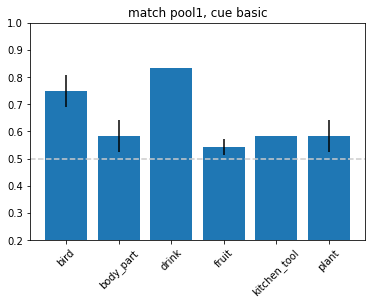

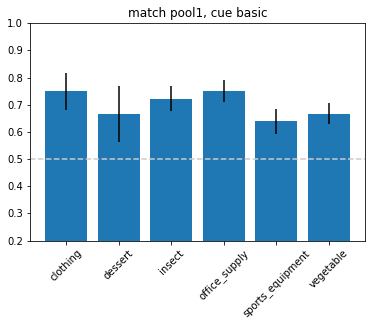

In [17]:
cc = 0; # basic
ii = 1; # pool1 (hardest)

for cbi, cb in enumerate([1,2]):

    vals = acc_by_supcat[cbi][subjects_use[subject_cb==cb],:,:,:]

    supnames = super_names_eachset[cbi]

    plot_vals = vals[:,cc,ii,:]
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])
    plt.figure()
    plt.bar(np.arange(len(meanvals)), meanvals)
    plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, linestyle='none', color='k')
    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')
    plt.xticks(np.arange(len(meanvals)), supnames, rotation=45)
    plt.ylim([0.2, 1.0])

    plt.title('%s, %s'%(image_type_names[ii], cue_level_names[cc]))

In [18]:
super_names_eachset

[array(['bird', 'body_part', 'drink', 'fruit', 'kitchen_tool', 'plant'],
       dtype=object),
 array(['clothing', 'dessert', 'insect', 'office_supply',
        'sports_equipment', 'vegetable'], dtype=object)]

In [19]:
is_natural = [np.array([1,1,0,1,0,1]).astype(bool), \
              np.array([0,0,1,0,0,1]).astype(bool)]
[super_names_eachset[cbi][is_natural[cbi]] for cbi in [0,1]], \
[super_names_eachset[cbi][~is_natural[cbi]] for cbi in [0,1]]

([array(['bird', 'body_part', 'fruit', 'plant'], dtype=object),
  array(['insect', 'vegetable'], dtype=object)],
 [array(['drink', 'kitchen_tool'], dtype=object),
  array(['clothing', 'dessert', 'office_supply', 'sports_equipment'],
        dtype=object)])

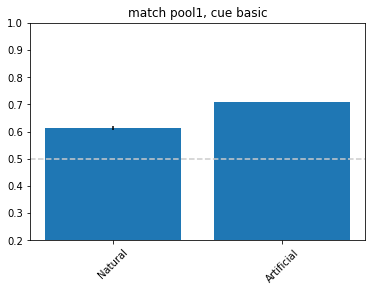

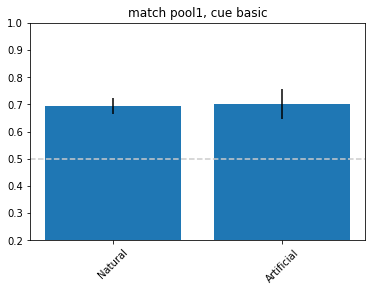

In [20]:
cc = 0; # basic
ii = 1; # pool1 (hardest)

for cbi, cb in enumerate([1,2]):

    vals = acc_by_supcat[cbi][subjects_use[subject_cb==cb],:,:,:]

    supnames = super_names_eachset[cbi]

    plot_vals = vals[:,cc,ii,:]
    
    # average over natural and artificial superordinate categories
    plot_vals = np.concatenate([np.mean(plot_vals[:,is_natural[cbi]==nn], axis=1, keepdims=True) \
                 for nn in [True, False]], axis=1)
    kind_names = ['Natural','Artificial']
   
    
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])
    plt.figure()
    plt.bar(np.arange(len(meanvals)), meanvals)
    plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, linestyle='none', color='k')
    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')
    plt.xticks(np.arange(len(meanvals)), kind_names, rotation=45)
    plt.ylim([0.2, 1.0])

    plt.title('%s, %s'%(image_type_names[ii], cue_level_names[cc]))

In [132]:
meanvals

array([0.75      , 0.58333333, 0.83333333, 0.54166667, 0.58333333,
       0.58333333])

In [95]:
np.unique(np.array(info['super_name'])[inds])

array(['bird', 'body_part', 'drink', 'fruit', 'kitchen_tool', 'plant'],
      dtype=object)

In [70]:
super_intact_acc = acc_by_condition[:,1,0]

In [71]:
cue_level_vals, image_type_vals

(array(['basic', 'super'], dtype=object), array([0., 1., 2., 3., 4.]))

In [106]:
subject_cb[subjects_use]

array([1., 1., 2., 2., 2.])

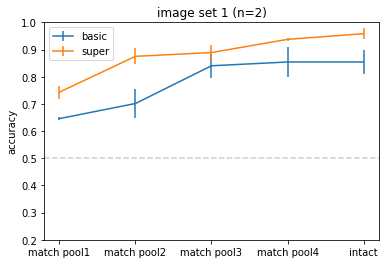

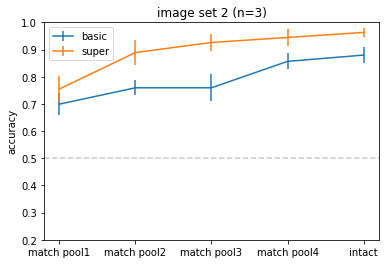

In [108]:
for cb in [1,2]:

    subjects_plot = (subject_cb==cb) & subjects_use
    n_subs_plot = np.sum(subjects_plot)
    
    plt.figure()
    ax = plt.subplot(1,1,1)

    lh = []
    for cc, cue in enumerate(cue_level_vals):

        vals = acc_by_condition[subjects_plot,cc,:]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)

        h = plt.errorbar(np.arange(n_image_types), meanvals[type_order_plot], semvals[type_order_plot])
        # h, = plt.plot(vals[type_order_plot], '.-')
        plt.xticks(np.arange(n_image_types), image_type_names[type_order_plot])
        lh.append(h)

    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')

    ax.legend(lh, cue_level_vals)

    plt.ylabel('accuracy')

    plt.ylim([0.2, 1.0])
    
    plt.title('image set %d (n=%d)'%(cb,n_subs_plot))

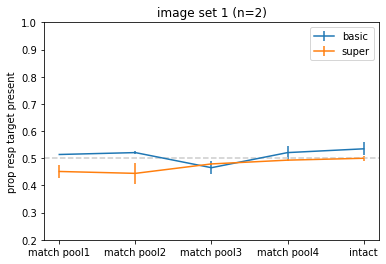

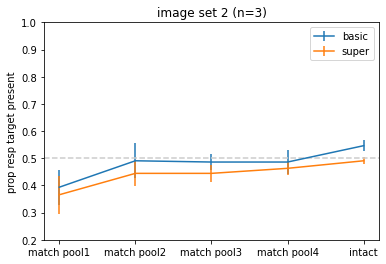

In [109]:
for cb in [1,2]:

    subjects_plot = (subject_cb==cb) & subjects_use
    n_subs_plot = np.sum(subjects_plot)

    plt.figure()
    ax = plt.subplot(1,1,1)

    lh = []
    for cc, cue in enumerate(cue_level_vals):

        vals = propyes_by_condition[subjects_plot,cc,:]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)

        h = plt.errorbar(np.arange(n_image_types), meanvals[type_order_plot], semvals[type_order_plot])

        plt.xticks(np.arange(n_image_types), image_type_names[type_order_plot])
        lh.append(h)

    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')

    ax.legend(lh, cue_level_vals)

    plt.ylabel('prop resp target present')

    plt.ylim([0.2, 1.0])
    
    plt.title('image set %d (n=%d)'%(cb,n_subs_plot))

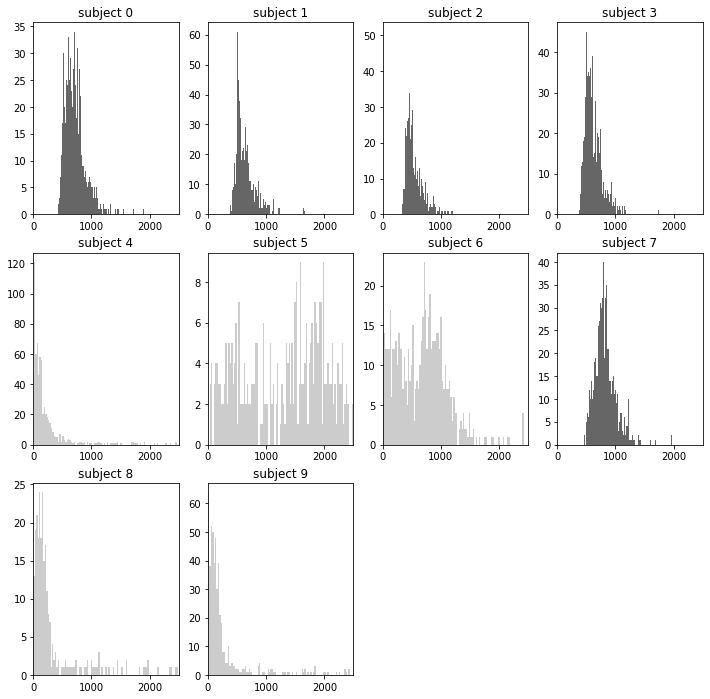

In [111]:
plt.figure(figsize=(12,12))
npy = int(np.ceil(np.sqrt(n_subjects)))
npx = int(np.ceil(n_subjects/npy))
xlims = [0, 2500]


for si in range(n_subjects):

    plt.subplot(npx, npy, si+1)
    
    rts = subject_data[si]['rt']
    
    if subjects_use[si]:
        plt.hist(rts,100, color=[0.4, 0.4, 0.4]);
    else:
        plt.hist(rts,100, color=[0.8, 0.8, 0.8]);
    plt.title('subject %d'%si)
    
    plt.xlim(xlims)